# imports

In [87]:
from Bio import Entrez
import requests,math,pickle,time
import networkx, obonet
import numpy as np ,pandas as pd, matplotlib.pyplot as plt
import arabic_reshaper
import multiprocessing as mp
from sklearn.metrics.cluster import *
from bidi.algorithm import get_display
from functools import partial
from IPython.display import clear_output
import sys
if sys.version_info[0] < 3: 
    from StringIO import StringIO
else:
    from io import StringIO

def fa(text):
    return get_display(arabic_reshaper.reshape(u'%s' % str(text)))

# Init

In [102]:
num_cores = max(mp.cpu_count() - 3, 1)
dataset_name = "Toy_Mediom"
!mkdir -p ./Output/{Dataset_Name}/figs

# For Toy_*

In [103]:
with open(f"./Dataset/{dataset_name}/anonymous.fasta", 'r') as file:
    lines = [line for line in file.read().split('\n') if len(line) > 0]
    contigs = pd.DataFrame(
        {
            '#anonymous_gsa_id': lines[0::2],
            'contig': lines[1::2]
        },
        columns=['#anonymous_gsa_id', 'contig'])
    contigs['#anonymous_gsa_id'] = contigs['#anonymous_gsa_id'].apply(
        lambda x: x[1:])
del(lines)
contigs.head(2)

df = pd.read_csv(f"./Dataset/{dataset_name}/mapping.tsv", sep='\t')
contigs = pd.merge(contigs, df, how='inner', on='#anonymous_gsa_id')
contigs["contig_length"] = contigs["contig"].apply(lambda x: len(x))
contigs.head(2)

,#anonymous_gsa_id,contig,genome_id,tax_id,sequence_id,number_reads,contig_length
0,M2|P|C0,CATATACTTCATTAATATCATTAAAATCCTTTAAATCTTTTACGAA...,1151347.1,1151347,NZ_AVJV01000079.1,56,1668
1,M2|P|C1,GGTCTTCAAAGTGCGCGATCACGTCGTCGTTCGGGATCAGGCAGGA...,1158759.1,1158759,NZ_KB897962.1,312,5427


In [104]:
abundances = pd.read_csv(f"./Dataset/{dataset_name}/abundances.tsv", sep='\t',header=None)
abundances.columns = ['genome_id','sequence_id','genome_fna','freq','sequence_bp','']
print(abundances.shape)
abundances.head()

(12627, 6)


,genome_id,sequence_id,genome_fna,freq,sequence_bp,
0,457429.1,NZ_CM000950.1,457429.1.fna,25.112534,8133379,c
1,272951.1,NZ_AABW01000001.1,272951.1.fna,1.376710,1250021,c
2,457393.1,NZ_GL622500.1,457393.1.fna,6.230714,1285632,c
3,457393.1,NZ_GL622501.1,457393.1.fna,6.230714,553429,c
4,457393.1,GL622502.1,457393.1.fna,6.230714,462086,c


In [105]:
genome2freq = {}
for genome in abundances['genome_id'].unique():
    data = abundances[abundances['genome_id']==genome]        
    freq = data.iloc[0,:]['freq']
    genome2freq[genome] = freq
genome2freq = dict(sorted(genome2freq.items(), key=lambda item: item[1]))

In [106]:
list(genome2freq.keys())[0]

658085.1

In [107]:
def getTaxName(genome_id):
    Entrez.email = 'abolhasani.eliya@gmail.com'
    handle = Entrez.efetch('taxonomy', 
                       id= [str(genome_id)]
                       , rettype='xml')
    response = Entrez.read(handle)
    return response[0]

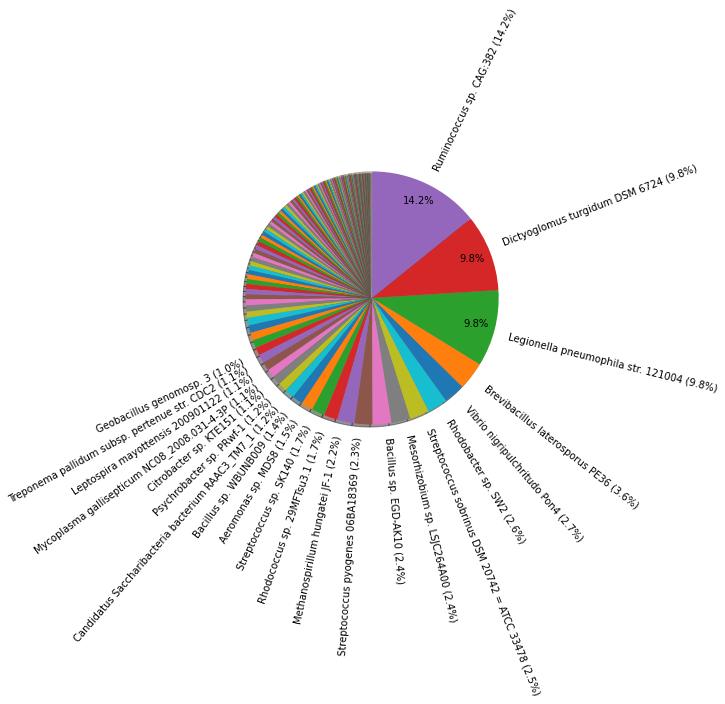

In [108]:
def my_autopct(pct):
    if(pct >= 5):
        return '%.1f' % pct + '%'
    return ''
    
s = sum(genome2freq.values())
labels = []
for key,value in genome2freq.items():
    if( value > s * 0.01):               
        pct = ' '
        pct = str(round(value/s*100,1)) + "%"
        labels.append(getTaxName(key)['ScientificName']+ f' ({pct})')
    else:
        labels.append('')
sizes = genome2freq.values()
explode = [0 for _ in range(len(sizes))]
plt.figure(num=None,figsize=(5,5))
ax = plt.gca()
ax.pie(sizes, explode=explode, labels=labels, autopct=my_autopct,
        shadow=True, startangle=90,rotatelabels=True,pctdistance=0.85)
ax.axis('equal')  
plt.savefig(f"./Output/{dataset_name}/figs/bactria_frequency_pie.svg")
plt.show()

# for ariways, urog,....

In [110]:
with open(f"./Dataset/{dataset_name}/contigs.fna", 'r') as file:
    lines = [line for line in file.read().split('\n') if len(line) > 0]
ids = []
contigs = []
s = ''
for l in lines:
    if(l[0]=='>'):
        ids.append(l)        
        contigs.append(s)
        s = ''
    else:
        s += l    
contigs.append(s)
contigs = contigs[1:]

contigs = pd.DataFrame(
        {
            '#anonymous_gsa_id': ids,
            'contig': contigs
        },
columns=['#anonymous_gsa_id', 'contig'])
contigs['#anonymous_gsa_id'] = contigs['#anonymous_gsa_id'].apply(lambda x: x[1:])
del(lines)
contigs.head(2)

,#anonymous_gsa_id,contig
0,S4C8,GTTATAATTTCCCGGCTGGATCTCCTTGAAATCATCAGACAAAATA...
1,S4C16,CGAGCAAACGAAGGCCGTACTAGAGATTCAGGCCAAGTGGAAGACT...


In [111]:
info = pd.read_csv(f"./Dataset/{dataset_name}/reference.tsv", sep='\t',header=None)
info.columns = ['#anonymous_gsa_id','OTU','Genbank Accession Number','a','b']

df = pd.read_csv(f"./Dataset/{dataset_name}/taxonomy.tsv", sep='\t',header=None)
df.columns=['OTU','Bacteria','Family']
info = pd.merge(info, df, how='inner', on='OTU')

contigs = pd.merge(contigs, info, how='inner', on='#anonymous_gsa_id')
contigs.head(2)

,#anonymous_gsa_id,contig,OTU,Genbank Accession Number,a,b,Bacteria,Family
0,S4C8,GTTATAATTTCCCGGCTGGATCTCCTTGAAATCATCAGACAAAATA...,OTU_97.38219.0,CP015399.1,2449858,2453454,Lachnoclostridium sp. YL32,Lachnoclostridium
1,S4C16,CGAGCAAACGAAGGCCGTACTAGAGATTCAGGCCAAGTGGAAGACT...,OTU_97.20930.0,AE015924.1,1271118,1273294,Porphyromonas gingivalis,Porphyromonas


In [121]:
with np.load(f'./Dataset/{dataset_name}/abundance_old.npz') as data:
    d = data['arr_0']

In [143]:
df = contigs[contigs['OTU']=='OTU_97.38219.0']
print(df['contig'].apply(lambda x : len(x))[0])
df['a']

3597


0        2449858
18        590051
32        515869
35        739586
39       1860743
          ...   
30077    5294689
30082    1570684
30083    5855839
30085    5026205
30114    4840049
Name: a, Length: 1296, dtype: int64

In [135]:
sum(d[contigs[contigs['OTU']=='OTU_97.38219.0'].index,:])

array([2.6298201e-02, 0.0000000e+00, 2.0791945e-01, 3.9093170e-02,
       1.1132900e-02, 4.5642802e-01, 2.8636523e+03, 8.6693096e-01,
       3.9553709e-02, 7.8102446e-01], dtype=float32)

In [127]:
with np.load(f'./Dataset/{dataset_name}/abundance.npz') as data:
    d = data['arr_0']

In [129]:
d[2,:]

array([0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 2.35598,
       0.     , 0.     , 0.     ], dtype=float32)

In [93]:
bactria2freq = {}
for bactria in contigs['Bacteria'].unique():
    data = contigs[contigs['Bacteria']==bactria]        
    freq = data.iloc[0,:]['freq']
    bactria2freq[bactria] = freq
bactria2freq = dict(sorted(bactria2freq.items(), key=lambda item: item[1]))

KeyError: 'freq'

In [ ]:
def my_autopct(pct):
    return ('%.1f' % pct) if pct > 5 else ''
s = sum(genome2freq.values())
labels = []
for key,value in genome2freq.items():
    if( value > s * 0.05):
        labels.append(key)
    else:
        labels.append('')
sizes = genome2freq.values()#[15, 30, 45, 10]
explode = [0 for _ in range(len(sizes))]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct=my_autopct,
        shadow=True, startangle=90)
ax1.axis('equal')  
plt.show()

# Show statistic result

In [112]:
# show description of contigs and contigs length histogram.
contigsLenght = contigs['contig'].apply(lambda x: len(x))
print(f'contigs number :  {contigs.shape[0]}')
try:
    print(f"number of genomes:  {len(contigs['genome_id'].unique())}")
except:
    print(f"number of genomes:  {len(contigs['Bacteria'].unique())}")
print(f'min : {contigsLenght.min()}')
print(f'max : {contigsLenght.max()}')
print(f'mean : {round(contigsLenght.mean(),2)}')
print(f'median : {round(np.median(contigsLenght),2)}')
print(f'1st quartiles : {round(np.percentile(contigsLenght, 25),2)}')
print(f'median : {round(np.median(contigsLenght),2)}')
print(f'3rd quartiles : {round(np.percentile(contigsLenght, 75),2)}')
print(f'standard deviation : {round(np.std(contigsLenght),2)}')
print(f'variance : {round(np.var(contigsLenght),2)}')

contigs number :  187685
number of genomes:  266
min : 2000
max : 6186826
mean : 8812.49
median : 3286.0
1st quartiles : 2460.0
median : 3286.0
3rd quartiles : 5233.0
standard deviation : 90102.75
variance : 8118505497.41
